# [**Visualisation de la structure de la bourse**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/applications/plot_stock_market.ipynb)<br/>([*Visualizing the stock market structure*](https://scikit-learn.org/stable/auto_examples/applications/plot_stock_market.html))

Cet exemple utilise plusieurs techniques d'apprentissage non supervisé pour extraire la structure du marché boursier à partir des variations des cotations historiques.

La quantité que nous utilisons est la variation quotidienne du prix de cotation : les cotations liées ont tendance à fluctuer les unes par rapport aux autres au cours d'une journée.

In [1]:
# Author: Gael Varoquaux gael.varoquaux@normalesup.org
# License: BSD 3 clause

# Récupérer les données sur Internet

Les données datent de 2003 à 2008. C'est raisonnablement calme : (il n'y a pas si longtemps pour que nous ayons des entreprises de haute technologie, et avant le krach de 2008). Ce type de données historiques peut être obtenu à partir d'API telles que quandl.com et alphavantage.co .

In [2]:
import sys
import numpy as np
import pandas as pd

symbol_dict = {
    "TOT": "Total",
    "XOM": "Exxon",
    "CVX": "Chevron",
    "COP": "ConocoPhillips",
    "VLO": "Valero Energy",
    "MSFT": "Microsoft",
    "IBM": "IBM",
    "TWX": "Time Warner",
    "CMCSA": "Comcast",
    "CVC": "Cablevision",
    "YHOO": "Yahoo",
    "DELL": "Dell",
    "HPQ": "HP",
    "AMZN": "Amazon",
    "TM": "Toyota",
    "CAJ": "Canon",
    "SNE": "Sony",
    "F": "Ford",
    "HMC": "Honda",
    "NAV": "Navistar",
    "NOC": "Northrop Grumman",
    "BA": "Boeing",
    "KO": "Coca Cola",
    "MMM": "3M",
    "MCD": "McDonald's",
    "PEP": "Pepsi",
    "K": "Kellogg",
    "UN": "Unilever",
    "MAR": "Marriott",
    "PG": "Procter Gamble",
    "CL": "Colgate-Palmolive",
    "GE": "General Electrics",
    "WFC": "Wells Fargo",
    "JPM": "JPMorgan Chase",
    "AIG": "AIG",
    "AXP": "American express",
    "BAC": "Bank of America",
    "GS": "Goldman Sachs",
    "AAPL": "Apple",
    "SAP": "SAP",
    "CSCO": "Cisco",
    "TXN": "Texas Instruments",
    "XRX": "Xerox",
    "WMT": "Wal-Mart",
    "HD": "Home Depot",
    "GSK": "GlaxoSmithKline",
    "PFE": "Pfizer",
    "SNY": "Sanofi-Aventis",
    "NVS": "Novartis",
    "KMB": "Kimberly-Clark",
    "R": "Ryder",
    "GD": "General Dynamics",
    "RTN": "Raytheon",
    "CVS": "CVS",
    "CAT": "Caterpillar",
    "DD": "DuPont de Nemours",
}


symbols, names = np.array(sorted(symbol_dict.items())).T

quotes = []

for symbol in symbols:
    print("Fetching quote history for %r" % symbol, file=sys.stderr)
    url = (
        "https://raw.githubusercontent.com/scikit-learn/examples-data/"
        "master/financial-data/{}.csv"
    )
    quotes.append(pd.read_csv(url.format(symbol)))

close_prices = np.vstack([q["close"] for q in quotes])
open_prices = np.vstack([q["open"] for q in quotes])

# The daily variations of the quotes are what carry the most information
variation = close_prices - open_prices

Fetching quote history for 'AAPL'
Fetching quote history for 'AIG'
Fetching quote history for 'AMZN'
Fetching quote history for 'AXP'
Fetching quote history for 'BA'
Fetching quote history for 'BAC'
Fetching quote history for 'CAJ'
Fetching quote history for 'CAT'
Fetching quote history for 'CL'
Fetching quote history for 'CMCSA'
Fetching quote history for 'COP'
Fetching quote history for 'CSCO'
Fetching quote history for 'CVC'
Fetching quote history for 'CVS'
Fetching quote history for 'CVX'
Fetching quote history for 'DD'
Fetching quote history for 'DELL'
Fetching quote history for 'F'
Fetching quote history for 'GD'
Fetching quote history for 'GE'
Fetching quote history for 'GS'
Fetching quote history for 'GSK'
Fetching quote history for 'HD'
Fetching quote history for 'HMC'
Fetching quote history for 'HPQ'
Fetching quote history for 'IBM'
Fetching quote history for 'JPM'
Fetching quote history for 'K'
Fetching quote history for 'KMB'
Fetching quote history for 'KO'
Fetching quote h

# Apprentissage d'une structure de graphe

Nous utilisons une estimation de covariance inverse creuse pour trouver quelles citations sont corrélées conditionnellement aux autres. Plus précisément, la covariance inverse creuse nous donne un graphe, c'est-à-dire une liste de connexions. Pour chaque symbole, les symboles qui lui sont également reliés sont ceux utiles pour expliquer ses fluctuations.

In [3]:
from sklearn import covariance

alphas = np.logspace(-1.5, 1, num=10)
edge_model = covariance.GraphicalLassoCV(alphas=alphas)

# standardize the time series: using correlations rather than covariance
# former is more efficient for structure recovery
X = variation.copy().T
X /= X.std(axis=0)
edge_model.fit(X)

GraphicalLassoCV(alphas=array([ 0.03162278,  0.05994843,  0.11364637,  0.21544347,  0.40842387,
        0.77426368,  1.46779927,  2.7825594 ,  5.27499706, 10.        ]))

# Clustering utilisant la propagation par affinité

Nous utilisons le regroupement pour regrouper les citations qui se comportent de la même manière. Ici, parmi les [**différentes techniques de clustering** (2.3)](https://scikit-learn.org/stable/modules/clustering.html#clustering) disponibles dans le scikit-learn, nous utilisons la [**propagation d'affinité** (2.3.3)](https://scikit-learn.org/stable/modules/clustering.html#affinity-propagation) car elle n'impose pas de clusters de taille égale, et elle peut choisir automatiquement le nombre de clusters à partir des données.

Notez que cela nous donne une indication différente du graphique, car le graphique reflète les relations conditionnelles entre les variables, tandis que le regroupement reflète les propriétés marginales : les variables regroupées peuvent être considérées comme ayant un impact similaire au niveau du marché boursier complet.

In [4]:
from sklearn import cluster

_, labels = cluster.affinity_propagation(edge_model.covariance_, random_state=0)
n_labels = labels.max()

for i in range(n_labels + 1):
    print(f"Cluster {i + 1}: {', '.join(names[labels == i])}")

Cluster 1: Apple, Amazon, Yahoo
Cluster 2: Comcast, Cablevision, Time Warner
Cluster 3: ConocoPhillips, Chevron, Total, Valero Energy, Exxon
Cluster 4: Cisco, Dell, HP, IBM, Microsoft, SAP, Texas Instruments
Cluster 5: Boeing, General Dynamics, Northrop Grumman, Raytheon
Cluster 6: AIG, American express, Bank of America, Caterpillar, CVS, DuPont de Nemours, Ford, General Electrics, Goldman Sachs, Home Depot, JPMorgan Chase, Marriott, McDonald's, 3M, Ryder, Wells Fargo, Wal-Mart
Cluster 7: GlaxoSmithKline, Novartis, Pfizer, Sanofi-Aventis, Unilever
Cluster 8: Kellogg, Coca Cola, Pepsi
Cluster 9: Colgate-Palmolive, Kimberly-Clark, Procter Gamble
Cluster 10: Canon, Honda, Navistar, Sony, Toyota, Xerox


# Intégration dans l'espace 2D

À des fins de visualisation, nous devons disposer les différents symboles sur un canevas 2D. Pour cela, nous utilisons des techniques d'[**apprentissage de variétés** (2.2)](https://scikit-learn.org/stable/modules/manifold.html) pour récupérer l'incorporation 2D. Nous utilisons un eigen_solver dense pour atteindre la reproductibilité (arpack est initié avec les vecteurs aléatoires que nous ne contrôlons pas). De plus, nous utilisons un grand nombre de voisins pour capturer la structure à grande échelle

In [5]:
# Finding a low-dimension embedding for visualization: find the best position of
# the nodes (the stocks) on a 2D plane

from sklearn import manifold

node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver="dense", n_neighbors=6
)

embedding = node_position_model.fit_transform(X.T).T

# Visualisation

Les sorties des 3 modèles sont combinées dans un graphique 2D où les nœuds représentent les stocks et les arêtes :
* les étiquettes de cluster sont utilisées pour définir la couleur des nœuds
* le modèle de covariance creux est utilisé pour afficher la force des arêtes
* l'encastrement 2D permet de positionner les nœuds dans le plan

Cet exemple contient une bonne quantité de code lié à la visualisation, car la visualisation est cruciale ici pour afficher le graphique. L'un des défis consiste à positionner les étiquettes en minimisant le chevauchement. Pour cela nous utilisons une heuristique basée sur la direction du plus proche voisin le long de chaque axe.

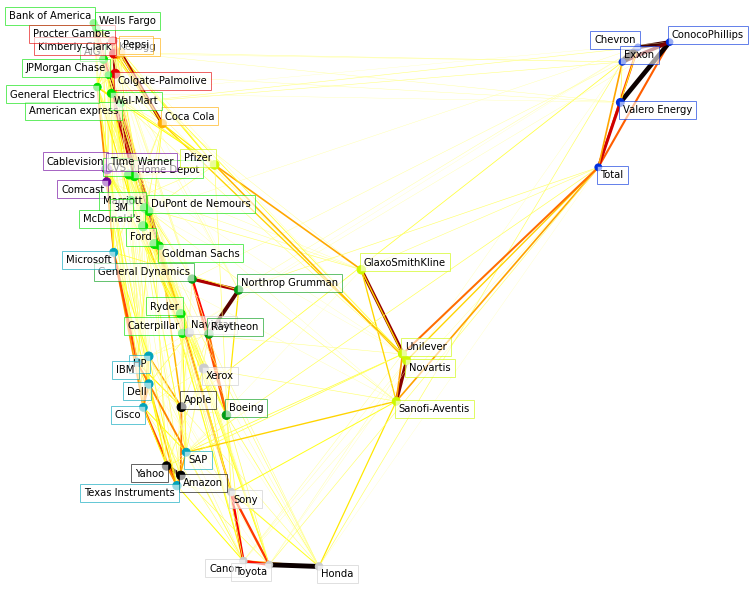

In [6]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

plt.figure(1, facecolor="w", figsize=(10, 8))
plt.clf()
ax = plt.axes([0.0, 0.0, 1.0, 1.0])
plt.axis("off")

# Plot the graph of partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = np.abs(np.triu(partial_correlations, k=1)) > 0.02

# Plot the nodes using the coordinates of our embedding
plt.scatter(
    embedding[0], embedding[1], s=100 * d**2, c=labels, cmap=plt.cm.nipy_spectral
)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [
    [embedding[:, start], embedding[:, stop]] for start, stop in zip(start_idx, end_idx)
]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(
    segments, zorder=0, cmap=plt.cm.hot_r, norm=plt.Normalize(0, 0.7 * values.max())
)
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(zip(names, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = "left"
        x = x + 0.002
    else:
        horizontalalignment = "right"
        x = x - 0.002
    if this_dy > 0:
        verticalalignment = "bottom"
        y = y + 0.002
    else:
        verticalalignment = "top"
        y = y - 0.002
    plt.text(
        x,
        y,
        name,
        size=10,
        horizontalalignment=horizontalalignment,
        verticalalignment=verticalalignment,
        bbox=dict(
            facecolor="w",
            edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
            alpha=0.6,
        ),
    )

plt.xlim(
    embedding[0].min() - 0.15 * embedding[0].ptp(),
    embedding[0].max() + 0.10 * embedding[0].ptp(),
)
plt.ylim(
    embedding[1].min() - 0.03 * embedding[1].ptp(),
    embedding[1].max() + 0.03 * embedding[1].ptp(),
)

plt.show()